**Задачи**:
- использовать предобученные различные эмбеддинги для работы с текстовыми данными;
- применить полученные эмбеддинги для моделей классификации.


**Dataset Toxic Comment**

https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data  

Чтобы сократить время получения эмбеддингов и обучения модели, будет использован только один датасет train.csv и 2 000 первых строк.

В нём предоставлены комментарии из «Википедии», которые были помечены оценщиками как содержащие токсичное поведение. Виды токсичности:

- toxic,
- severe_toxic,
- obscene,
- threat,
- insult,
- identity_hate.

In [ ]:
!pip install sentence_transformers

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import BertModel, BertTokenizer
from sentence_transformers import SentenceTransformer

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, f1_score
from torch.optim.lr_scheduler import StepLR

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
full_data_path = "drive/MyDrive/Skillbox/Skillbox_8/train.csv"
full_data = pd.read_csv(full_data_path, usecols=lambda column: column != 'id', nrows=2000)

In [ ]:
full_data.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
full_data.shape

(2000, 7)

### Баланс классов

In [ ]:
# Выбираем столбцы с метками
labels_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Создадим новый столбец no_labels, который будет равен 1, если все метки равны 0
full_data['no_labels'] = (full_data[labels_columns].sum(axis=1) == 0).astype(int)

# Добавляем no_labels в список меток
labels_columns.append('no_labels')

# Подсчитываем количество комментариев для каждой метки
label_counts = full_data[labels_columns].sum()

# Подсчитываем общее количество комментариев
total_comments = len(full_data)

# Вычисляем процентное соотношение для каждой метки
label_percentages = label_counts / total_comments * 100

for label in labels_columns:
    print(f"Метка '{label}':")
    print(f"Количество комментариев: {label_counts[label]}")
    print(f"Процент от общего числа комментариев: {label_percentages[label]:.2f}%")
    print()

Метка 'toxic':
Количество комментариев: 199
Процент от общего числа комментариев: 9.95%

Метка 'severe_toxic':
Количество комментариев: 20
Процент от общего числа комментариев: 1.00%

Метка 'obscene':
Количество комментариев: 101
Процент от общего числа комментариев: 5.05%

Метка 'threat':
Количество комментариев: 9
Процент от общего числа комментариев: 0.45%

Метка 'insult':
Количество комментариев: 104
Процент от общего числа комментариев: 5.20%

Метка 'identity_hate':
Количество комментариев: 22
Процент от общего числа комментариев: 1.10%

Метка 'no_labels':
Количество комментариев: 1790
Процент от общего числа комментариев: 89.50%



In [ ]:
full_data.drop('no_labels', axis=1, inplace=True)

### Распределение комментариев с несколькими метками


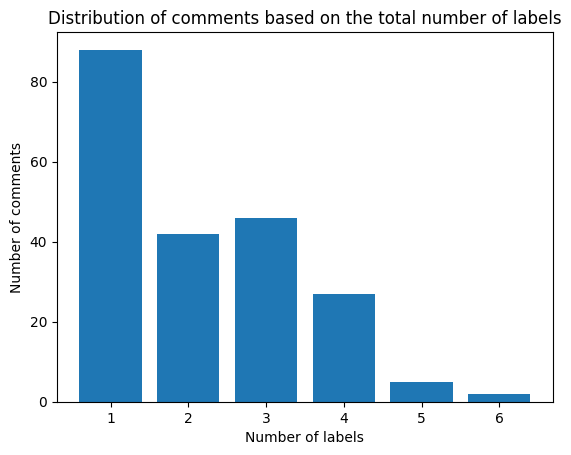

In [ ]:
labels_columns = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

non_zero_rows = full_data[(full_data[labels_columns] != 0).any(axis=1)]

num_labels_per_comment = non_zero_rows[labels_columns].sum(axis=1)

label_counts = num_labels_per_comment.value_counts().sort_index()

plt.bar(label_counts.index, label_counts.values)

plt.title('Distribution of comments based on the total number of labels')
plt.xlabel('Number of labels')
plt.ylabel('Number of comments')
plt.show()

### Предобработка данных

In [ ]:
def text_cleaner(text):
    # Преобразование текста в нижний регистр
    text = text.lower()

    # Удаление лишних пробелов
    text = re.sub(r'\s+', ' ', text)

    # Преобразование сокращений
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'m", " am", text)

    # Удаление знаков препинания
    text = re.sub(r'[^\w\s]', '', text)

    # Удаление стоп-слов
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_text = [word for word in tokens if word.lower() not in stop_words]

    # Лемматизация слов
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = [lemmatizer.lemmatize(word) for word in filtered_text]

    # Объединение лемматизированных слов обратно в текст
    cleaned_text = ' '.join(lemmatized_text)

    return cleaned_text

In [ ]:
full_data['cleaner_text'] = full_data['comment_text'].map(lambda comments : text_cleaner(comments))

In [ ]:
full_data[['comment_text', 'cleaner_text']]

,comment_text,cleaner_text
0,Explanation\nWhy the edits made under my usern...,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,daww match background colour seemingly stuck t...
2,"Hey man, I'm really not trying to edit war. It...",hey man really trying edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",make real suggestion improvement wondered sect...
4,"You, sir, are my hero. Any chance you remember...",sir hero chance remember page
...,...,...
1995,"Barek, why are you abu$ing the deletion functi...",barek abuing deletion function jut deleted bun...
1996,"Hannibal \n\nLike I said earlier, the only th...",hannibal like said earlier thing would comment...
1997,"""::The CTMU is not passing itself off as an """"...",ctmu passing academic theory langan member aca...
1998,"Siafu, I am getting access denied for GPS PPS....",siafu getting access denied gps pps say error ...


# BERT

### Получение эмбеддингов с помощью BERT

In [ ]:
# Загрузка предварительно обученной модели BERT
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
model = SentenceTransformer(model_name)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
embeddings = model.encode(full_data['cleaner_text'].tolist())

In [ ]:
embeddings.shape

(2000, 768)

### Обучение модели

In [ ]:
y = full_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, y, test_size=0.2, random_state=42)

In [ ]:
# Преобразование данных в тензоры PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Создание DataLoader для обучающего и тестового наборов данных
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [ ]:
# Определение модели
class ToxicityClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.9):
        super(ToxicityClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)  # Применяем dropout после активации
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [ ]:
# Параметры модели
input_size = embeddings.shape[1]
hidden_size = 256
output_size = 6

In [ ]:
# Создание модели
model = ToxicityClassifier(input_size, hidden_size, output_size)

In [ ]:
# Определение функции потерь и оптимизатора
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
# Пустые списки для хранения значений потерь и точности на обучающей и тестовой выборках
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Обучение модели
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Вычисление точности на обучающей выборке
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == torch.max(labels, 1)[1]).sum().item()

    # Сохранение значений потерь и точности на обучающей выборке
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    # Оценка модели на тестовой выборке
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Вычисление точности на тестовой выборке
            _, predicted_test = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted_test == torch.max(labels, 1)[1]).sum().item()

    # Сохранение значений потерь и точности на тестовой выборке
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct_test / total_test)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Test Loss: {test_losses[-1]}, Test Accuracy: {test_accuracies[-1]}")

Epoch 1, Train Loss: 0.2277225374430418, Train Accuracy: 0.389375, Test Loss: 0.17920410432494605, Test Accuracy: 0.99
Epoch 2, Train Loss: 0.13648180693387985, Train Accuracy: 0.613125, Test Loss: 0.12405055646712963, Test Accuracy: 0.99
Epoch 3, Train Loss: 0.1110575395077467, Train Accuracy: 0.606875, Test Loss: 0.10952933992330845, Test Accuracy: 0.99
Epoch 4, Train Loss: 0.10015433862805366, Train Accuracy: 0.73625, Test Loss: 0.10145281283901288, Test Accuracy: 0.99
Epoch 5, Train Loss: 0.09495098799467087, Train Accuracy: 0.82125, Test Loss: 0.09729544216623673, Test Accuracy: 0.99
Epoch 6, Train Loss: 0.0865780158340931, Train Accuracy: 0.83875, Test Loss: 0.09808950613324459, Test Accuracy: 0.99
Epoch 7, Train Loss: 0.08248386485502124, Train Accuracy: 0.904375, Test Loss: 0.09428485941428405, Test Accuracy: 0.99
Epoch 8, Train Loss: 0.0818163350969553, Train Accuracy: 0.89875, Test Loss: 0.09189473579709347, Test Accuracy: 0.99
Epoch 9, Train Loss: 0.0811031749472022, Train A

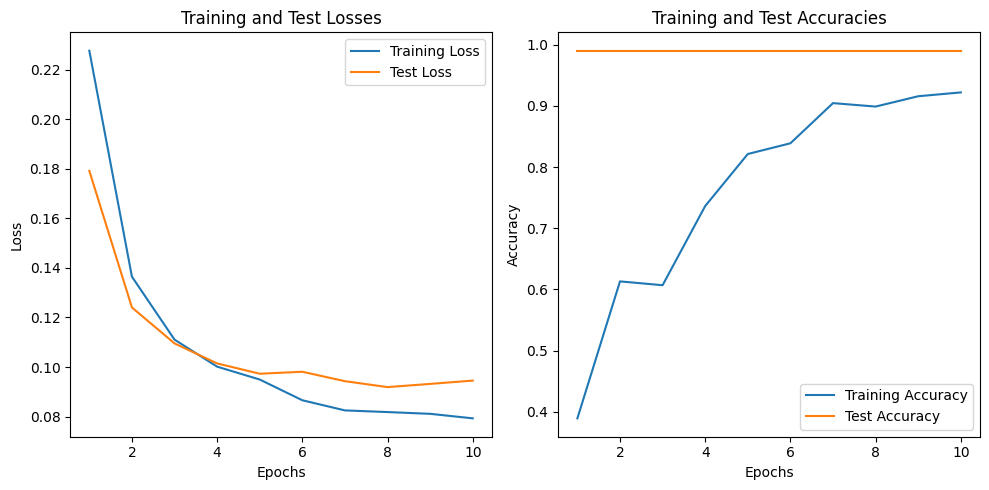

In [ ]:
# Построение графиков
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), train_losses, label='Training Loss')
plt.plot(range(1, 11), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), train_accuracies, label='Training Accuracy')
plt.plot(range(1, 11), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Получение вероятностей принадлежности каждому классу для тестового набора данных
probabilities = model(X_test_tensor)

In [ ]:
# Переводим тензоры PyTorch обратно в массивы numpy
predictions = probabilities.detach().numpy()

In [ ]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
results = []

for i in range(len(X_test)):
    sentence = full_data['cleaner_text'][i]
    traits = []

    for j, class_name in enumerate(class_names):
        if predictions[i][j] >= 0.5:
            traits.append(class_name)

    result = {'Предложение': sentence, 'Токсичные признаки': ', '.join(traits) if traits else 'Нет токсичных признаков'}
    for k, class_name in enumerate(class_names):
        result[class_name] = "{:.8f}".format(predictions[i][k])
    results.append(result)

In [ ]:
df_results = pd.DataFrame(results)
df_results

,Предложение,Токсичные признаки,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation edits made username hardcore metal...,Нет токсичных признаков,0.00163927,0.00000070,0.00010039,0.00000140,0.00014144,0.00000959
1,daww match background colour seemingly stuck t...,Нет токсичных признаков,0.02091039,0.00005428,0.00244954,0.00007944,0.00378463,0.00035612
2,hey man really trying edit war guy constantly ...,Нет токсичных признаков,0.01247668,0.00001752,0.00107505,0.00002748,0.00176398,0.00013157
3,make real suggestion improvement wondered sect...,Нет токсичных признаков,0.01601371,0.00005021,0.00208320,0.00007898,0.00280324,0.00035063
4,sir hero chance remember page,Нет токсичных признаков,0.01690183,0.00003040,0.00156294,0.00004865,0.00269798,0.00020930
...,...,...,...,...,...,...,...,...
395,rfc pretty much blew respect tried demand give...,Нет токсичных признаков,0.24574126,0.01739577,0.13003381,0.01584549,0.13833413,0.04194441
396,delete material complies wp policyaccording po...,Нет токсичных признаков,0.16734329,0.01057854,0.08913055,0.01382508,0.11626223,0.03025154
397,revert edits,Нет токсичных признаков,0.00264626,0.00000095,0.00013364,0.00000174,0.00021201,0.00001142
398,canonicity general involved long discussion ta...,Нет токсичных признаков,0.00791605,0.00002464,0.00111907,0.00004485,0.00179276,0.00019947


In [ ]:
_, y_true = torch.max(y_test_tensor, 1)

threshold = 0.5
predicted_labels = (predictions[:, 1] > threshold).astype(int)

# Вычисляем метрики
f1_weighted = f1_score(y_true, predicted_labels, average='weighted')
accuracy = accuracy_score(y_true, predicted_labels)

print("F1-score:", f1_weighted)
print("Accuracy:", accuracy)

F1-score: 0.9850251256281406
Accuracy: 0.99


# GPT-2

### Получение эмбеддингов с помощью GPT-2

In [ ]:
from transformers import GPT2Tokenizer, GPT2Model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2Model.from_pretrained('gpt2')

In [ ]:
model.to(device)

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [ ]:
# Tokenize и pad sequences
encoded_captions = tokenizer(
    full_data['cleaner_text'].tolist(),
    return_tensors='pt',
    padding=True,
    truncation=True)

In [ ]:
encoded_captions = {key: value.to(device) for key, value in encoded_captions.items()}

In [ ]:
input_ids = encoded_captions['input_ids']

In [ ]:
batch_size = 4

In [ ]:
# Инициализируем список для хранения embeddings
all_sentence_embeddings = []

# Разделим данные на батчи и передадим их в модель
for i in range(0, len(encoded_captions['input_ids']), batch_size):
    batch_input_ids = encoded_captions['input_ids'][i:i+batch_size].to(device)
    batch_attention_mask = encoded_captions['attention_mask'][i:i+batch_size].to(device)

    # Передаем батчи в модель
    with torch.no_grad():
        batch_outputs = model(batch_input_ids)

    # Извлекаем embeddings для каждого батча
    word_embeddings = batch_outputs.last_hidden_state

    # Mask для игнорирования padding tokens
    masked_word_embeddings = word_embeddings * batch_attention_mask.unsqueeze(-1).float()

    # Объединение сумм с учётом токенов без non-padding
    sentence_embeddings = masked_word_embeddings.sum(dim=1)

    # Нормализация по количеству токенов без non-padding
    sentence_embeddings /= batch_attention_mask.sum(dim=1, keepdim=True).float()

    # Добавляем embeddings батча в список
    all_sentence_embeddings.append(sentence_embeddings)

# Собираем все embeddings батчей в один список
all_sentence_embeddings = torch.cat(all_sentence_embeddings, dim=0)

In [ ]:
all_sentence_embeddings

tensor([[-0.0590, -0.2063,  0.0520,  ..., -0.5559,  0.2985,  0.1552],
        [ 0.1112, -0.2002, -0.4332,  ..., -0.0815,  0.2014,  0.0120],
        [-0.2627, -0.0598, -0.5898,  ..., -0.2396, -0.0921,  0.1119],
        ...,
        [-0.0285,  0.1508, -0.5740,  ..., -0.1132,  0.0610,  0.0258],
        [ 0.3496, -0.0034, -0.2851,  ..., -0.2645,  0.2554,  0.0244],
        [-0.0351, -0.2145, -0.7854,  ..., -0.0433,  0.0581,  0.0651]],
       device='cuda:0')

### Обучение модели


In [ ]:
y = full_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(all_sentence_embeddings, y, test_size=0.2, random_state=42)

In [ ]:
# Преобразование данных в тензоры PyTorch
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Создание DataLoader для обучающего и тестового наборов данных
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

<ipython-input-43-665e186764ef>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
<ipython-input-43-665e186764ef>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


In [ ]:
# Определение модели
class ToxicityClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob=0.9):
        super(ToxicityClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [ ]:
# Параметры модели
input_size = sentence_embeddings.shape[1]
hidden_size = 256
output_size = 6

In [ ]:
# Создание модели
model_elmo = ToxicityClassifier(input_size, hidden_size, output_size)

In [ ]:
model_elmo = model_elmo.to(device)

In [ ]:
# Определение функции потерь и оптимизатора
criterion = nn.BCELoss()
optimizer = optim.Adam(model_elmo.parameters())

In [ ]:
# Пустые списки для хранения значений потерь и точности на обучающей и тестовой выборках
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Обучение модели
for epoch in range(10):
    model_elmo.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        inputs = inputs.to(device)  # Переносим данные на устройство GPU
        labels = labels.to(device)  # Переносим метки на устройство GPU
        outputs = model_elmo(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Вычисление точности на обучающей выборке
        _, predicted_train = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == torch.argmax(labels, dim=1)).sum().item()

    # Сохранение значений потерь и точности на обучающей выборке
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)

    # Оценка модели на тестовой выборке
    model_elmo.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)  # Переносим данные на устройство GPU
            labels = labels.to(device)  # Переносим метки на устройство GPU
            outputs = model_elmo(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Вычисление точности на тестовой выборке
            _, predicted_test = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted_test == torch.argmax(labels, dim=1)).sum().item()

    # Сохранение значений потерь и точности на тестовой выборке
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(correct_test / total_test)

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Train Accuracy: {train_accuracies[-1]}, Test Loss: {test_losses[-1]}, Test Accuracy: {test_accuracies[-1]}")

Epoch 1, Train Loss: 0.42427744463086126, Train Accuracy: 0.3, Test Loss: 0.18629800700224364, Test Accuracy: 0.99
Epoch 2, Train Loss: 0.20111302480101587, Train Accuracy: 0.530625, Test Loss: 0.1694019393852124, Test Accuracy: 0.99
Epoch 3, Train Loss: 0.17018317855894566, Train Accuracy: 0.614375, Test Loss: 0.14653270519696748, Test Accuracy: 0.99
Epoch 4, Train Loss: 0.1593534354865551, Train Accuracy: 0.629375, Test Loss: 0.12977541897159356, Test Accuracy: 0.99
Epoch 5, Train Loss: 0.14460862502455712, Train Accuracy: 0.6825, Test Loss: 0.12070471707444924, Test Accuracy: 0.99
Epoch 6, Train Loss: 0.13212285812944174, Train Accuracy: 0.78, Test Loss: 0.11776272178842472, Test Accuracy: 0.99
Epoch 7, Train Loss: 0.13022976636886596, Train Accuracy: 0.838125, Test Loss: 0.11210219676677997, Test Accuracy: 0.99
Epoch 8, Train Loss: 0.1263528587669134, Train Accuracy: 0.82875, Test Loss: 0.10829816529384026, Test Accuracy: 0.99
Epoch 9, Train Loss: 0.11771380469202995, Train Accurac

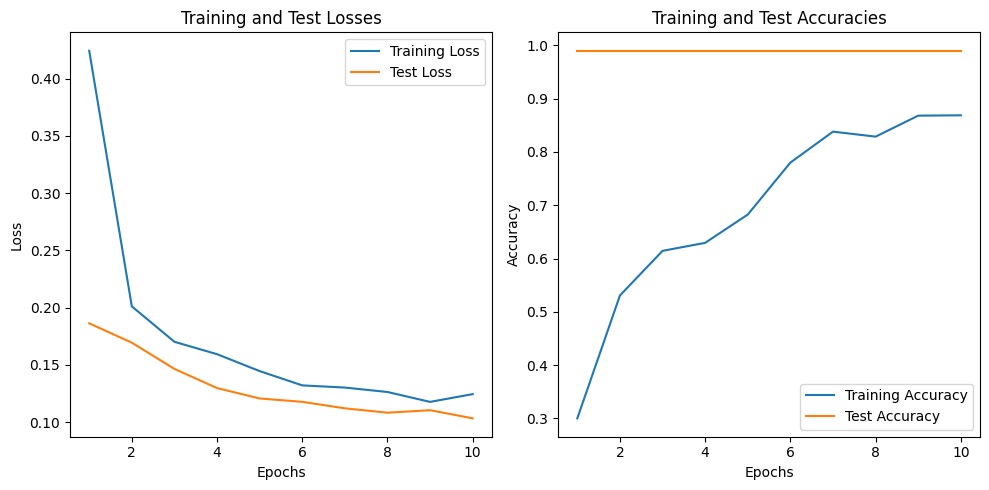

In [ ]:
# Построение графиков
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, 11), train_losses, label='Training Loss')
plt.plot(range(1, 11), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Test Losses')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 11), train_accuracies, label='Training Accuracy')
plt.plot(range(1, 11), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Получение вероятностей принадлежности каждому классу для тестового набора данных
probabilities = model_elmo(X_test_tensor)

In [ ]:
# Переносим тензор на CPU и преобразуем его в массив numpy
predictions = probabilities.detach().cpu().numpy()

In [ ]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
results = []

for i in range(len(X_test)):
    sentence = full_data['cleaner_text'][i]
    traits = []

    for j, class_name in enumerate(class_names):
        if predictions[i][j] >= 0.5:
            traits.append(class_name)

    result = {'Предложение': sentence, 'Токсичные признаки': ', '.join(traits) if traits else 'Нет токсичных признаков'}
    for k, class_name in enumerate(class_names):
        result[class_name] = "{:.8f}".format(predictions[i][k])
    results.append(result)

In [ ]:
df_results = pd.DataFrame(results)
df_results

,Предложение,Токсичные признаки,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation edits made username hardcore metal...,Нет токсичных признаков,0.03837077,0.00035408,0.00867829,0.00018786,0.01142941,0.00066078
1,daww match background colour seemingly stuck t...,Нет токсичных признаков,0.02835037,0.00013335,0.00473866,0.00005950,0.00658215,0.00022715
2,hey man really trying edit war guy constantly ...,Нет токсичных признаков,0.06087178,0.00072184,0.01682674,0.00036952,0.01977847,0.00125712
3,make real suggestion improvement wondered sect...,Нет токсичных признаков,0.04964199,0.00063366,0.01276049,0.00036812,0.01667559,0.00116650
4,sir hero chance remember page,Нет токсичных признаков,0.01567014,0.00002874,0.00202193,0.00001139,0.00281650,0.00005689
...,...,...,...,...,...,...,...,...
395,rfc pretty much blew respect tried demand give...,Нет токсичных признаков,0.17629899,0.01377024,0.09188492,0.00869990,0.09821349,0.02032663
396,delete material complies wp policyaccording po...,Нет токсичных признаков,0.06961047,0.00161285,0.02212920,0.00095746,0.02694193,0.00262009
397,revert edits,Нет токсичных признаков,0.03513831,0.00023658,0.00704832,0.00011899,0.00988239,0.00041809
398,canonicity general involved long discussion ta...,Нет токсичных признаков,0.01405299,0.00003749,0.00181273,0.00001672,0.00298059,0.00007239


In [ ]:
_, y_true = torch.max(y_test_tensor, 1)

threshold = 0.5
predicted_labels = (predictions[:, 1] > threshold).astype(int)

# Вычисляем метрики
f1_weighted = f1_score(y_true, predicted_labels, average='weighted')
accuracy = accuracy_score(y_true, predicted_labels)

print("F1-score:", f1_weighted)
print("Accuracy:", accuracy)

F1-score: 0.9850251256281406
Accuracy: 0.99
